In [1]:
import requests
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd

base_url = "https://monitor.protezionecivile.fvg.it/api"

In [2]:
def get_ids(from_date, to_date, radar_id=1, last = 10000, offset = 0):
    # radar 1 is the one with more observations: VMI and SRI are the most interesting

    endpoint = f"/radars/{radar_id}/products"
    url = base_url + endpoint

    params = {
        "from": from_date, 
        "to": to_date,
        "last": last,
        "offset": offset
    }

    try:
        response = requests.get(url, params=params)
        response.raise_for_status()
        
        data = response.json()
        # print(json.dumps(data, indent=4))
        
        # visualize the data using a df
        if data is not None:
            try:
                products = data.get("products", [])
                selected_data = [
                    {
                        "id": product.get("id"),
                        "name": product.get("name"),
                        "format": product.get("format"),
                        "date_time": product.get("dt")
                    }
                    for product in products
                ]

                df = pd.DataFrame(selected_data)
            except:
                print(data)
                df = None

        else :
            df = None

    except requests.exceptions.RequestException as e:
        print(f"An error occurred: {e}")

    return df

First, let's get familiar with the api.

In [3]:
get_ids("2024-10-24 03:00:00", "2024-10-24 03:01:00", radar_id=1, last=10000, offset=0)

,id,name,format,date_time
0,2447750,VMI,application/x-hdf5,2024-10-24 03:00:00
1,2447751,VMI,image/png,2024-10-24 03:00:00
2,2447752,HVMI,application/x-hdf5,2024-10-24 03:00:00
3,2447753,HVMI_NS,image/png,2024-10-24 03:00:00
4,2447754,HVMI_OE,image/png,2024-10-24 03:00:00
5,2447755,SRI,application/x-hdf5,2024-10-24 03:00:00
6,2447756,SRI,image/png,2024-10-24 03:00:00
7,2447757,SRILBM,application/x-hdf5,2024-10-24 03:00:00
8,2447758,SRILBM,image/png,2024-10-24 03:00:00
9,2447759,SRISV,application/x-hdf5,2024-10-24 03:00:00


VMI is the radar-detected maximum vertical reflectivity 

SRI is the Surface Rainfall Intensity

The SRT variable is the radar-detected precipitation cumulated on different durations

The SSI variable is the radar-detected storm severity index

HMC and LBM_V should be something about the wind

In [4]:
def get_image_product(product_id, file_name):
    endpoint = f"/products/{product_id}"
    url = base_url + endpoint
    headers = {
    "accept": "image/jpeg",
    }
    try:
        response = requests.get(url, headers=headers)
        response.raise_for_status()
        with open(file_name, "wb") as file:
            file.write(response.content)

    except requests.exceptions.RequestException as e:
        print(f"An error occurred: {e}")

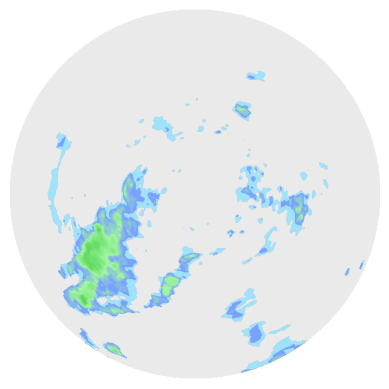

In [5]:
get_image_product(2447756, "images/2447756.jpg")

# Load and display the image
image_path = "images/2447756.jpg"
img = mpimg.imread(image_path)
plt.imshow(img)
plt.axis('off')
plt.show()

## Creating a df for the indexes of the product of interest

I decided to use the surface rainfall intensity because SRI the size of the images is smaller [500,500] than the size of the vertical reflectivity index VMI [2000,2000]

In [8]:
year = 2024
data_frames = []

for month in range(4, 11):
    max_day = 31
    id_df = pd.DataFrame()
    print(f"Month: {month}")
    if month == 4 or month == 6 or month == 9 or month == 11:
        max_day = 30
    for from_date in pd.date_range(f"{year}-{month}-01 00:00:00", f"{year}-{month}-{max_day} 00:00:00", freq="1D"):
        to_date = from_date + pd.Timedelta(days=1)
        try:
            df = get_ids(from_date, to_date, radar_id=1, last=10000, offset=0)
            if df is None:
                continue
        except requests.exceptions.RequestException as e:   
            print(f"An error occurred: {e}")
            continue
        # filter the data: keep only the products with the name "SRI" and jpeg format
        if not df.empty:
            df = df[df["name"].isin(["SRI"]) & (df["format"] == "image/png")]
        id_df = pd.concat([df,id_df], ignore_index=True)

    globals()[f"id_df_{month}"] = id_df
    data_frames.append(id_df)

Month: 4
Month: 5
Month: 6
Month: 7
Month: 8
Month: 9
Month: 10


In [9]:
id_df = pd.concat(data_frames[::-1], ignore_index=True)
id_df = id_df.drop(columns=["name", "format"])
# keep only unique values of the df wrt id
id_df = id_df.drop_duplicates(subset=['id'])

# save the dataframe to a csv file
id_df.to_csv("id_df_SRI_jpg_radar_1.csv", index=False)